# DaTacos

In [39]:
import warnings
import pandas as pd
from pandas.errors import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

B_ARTIST = "B-Artist"
B_WOA = "B-WoA"

Artist_nan = "Artist_nan"
WoA_nan = "WoA_nan"
both_nan = "both_nan"

data = pd.read_parquet("../data/intermediate/datacos_IOB.parquet").drop("ver_id", axis=1)

print(f"Videos without matched Artist entity: {round(len(data[data.part == Artist_nan])/len(data), 2)}")
print(f"Videos without matched Title entity: {round(len(data[data.part == WoA_nan])/len(data), 2)}")
print(f"Videos without any entity: {round(len(data[data.part == both_nan])/len(data), 2)}")


Videos without matched Artist entity: 0.03
Videos without matched Title entity: 0.02
Videos without any entity: 0.0


In [40]:
grouped = data.groupby(['part', 'split', 'set_id']).size().reset_index(name='i')
sizes = grouped.groupby(['part', 'split', 'i']).size().reset_index(name='num_set_ids')
pivoted = sizes.pivot_table(index=['part', 'split'], columns='i', values='num_set_ids', fill_value=0).reset_index()
pivoted


i,part,split,1,2,3,4,5,6,7,8,9,10,11,12,13
0,Artist_nan,TEST,340.0,57.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,WoA_nan,TEST,172.0,29.0,12.0,4.0,3.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,both_100,TEST,1526.0,1.0,6.0,7.0,12.0,31.0,36.0,69.0,131.0,199.0,241.0,185.0,80.0
3,both_nan,TEST,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,medium,TEST,428.0,145.0,46.0,29.0,10.0,10.0,3.0,6.0,1.0,0.0,0.0,0.0,0.0


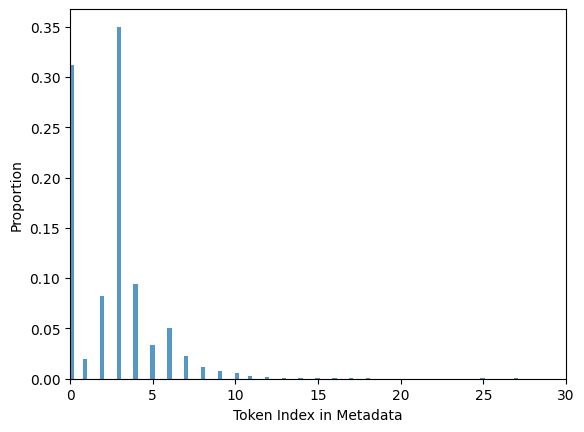

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

def get_first_idx(l: list, s: str):
    for i, e in enumerate(l):
        if e == s:
            return i
    return -1

series_woa = data.IOB.apply(lambda x: get_first_idx(x, "B-WoA"))
series_artist = data.IOB.apply(lambda x: get_first_idx(x, "B-Artist"))

mask = data.part.isin(["medium", "both_100"])

sns.histplot(series_woa[mask], stat="proportion")
plt.xlabel("Token Index in Metadata")
plt.xlim(0,30)
plt.show()


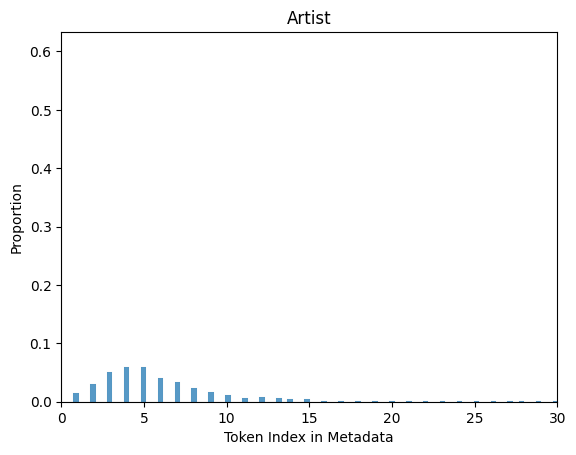

In [42]:
sns.histplot(series_artist[mask], stat="proportion")
plt.title("Artist")
plt.xlabel("Token Index in Metadata")
plt.xlim(0,30)
plt.show()


### Multiple artists, usually separated by "feat", "featuring", "vs"
- omitting feat. artist
    - eg. "dub spencer & trance hill feat the catch" vs. "dub spencer & trance hill"
- artist and feat. artist split by song title
    - eg. "theo croker SONG_TITLE feat dee dee bridgewater" Vs. "theo croker featuring dee dee bridgewater"
- both artists spearatly mentioned for "sugababes vs girls aloud"	
### Unfuzzy-Problem
Are these problems solvable by edit-distance-like approach?
- String + digit concatenated vs. not concatenated
    - eg. "equipe84" vs. "equipe 84"
    - eg. "06diphtheria" instead of "diphtheria"
- genetive in artist name
    - eg. "janice whales" instead of "janice whaley"
- absence of article "the"
    - eg. "cats" instead of "the cats"
- which pattern is this actually? encoding? wrong preprocessing?:
    - "robin\nfi?" in SHS metadata?
    - "all saints\ngb" ..
    - "sabrina\nph" ...
- wrong spacing
    - "di do" instead of "dido"
    - "vaughn deleath"	instead of "vaughn de leath"	
- missing single chars 
    - between tokens
        - eg "george wallace jr" instead of "george c wallace jr"
    - in tokens
        - eg "ariane moffat" instead of "ariane moffatt"
- typo
    - "rosanna eckert" instead of "rosana eckert"
- alternative name 
    - "european ensemble string quartett" instead of "european ensemble strings"
- "&" vs. "and" (eg. "jim and jesse" vs "jim & jesse")


In [43]:
data[data.part == Artist_nan].sample(10)[["yt_processed", "performer_perf_processed"]]


,yt_processed,performer_perf_processed
13427,"19. ""the resurrection stone"" - harry potter an...",[alexandre desplat]
3592,george michael & astrud gilberto - desafinado....,[astrud gilberto + george michael]
6139,i saw her standing there. hunchybunker. from t...,[bob leaper]
8406,louisiana fairy tale by the casini club orche...,[casani club band directed by charlie kunz]
10049,"""blue lou"" børge roger henrichsen og hans kvin...",[brge roger henrichsen og hans kvintet]
491,meet the raisins- shotgun. cavitysam. 'shotgun...,[california raisins]
1715,i'll remember april original. the real changes...,[dick foran]
4667,ella and louis stars fell on alabama. nagao ...,"[ella fitzgerald, louis armstrong]"
9284,the game of love (santana´s song) - vintage ca...,[sarah menescal]
5018,my ideal - erroll garner and his trio. nichol...,[erroll garner trio]


In [44]:
data[data.part == WoA_nan].sample(10)[["yt_processed", "title_perf_processed"]]


,yt_processed,title_perf_processed
12356,"home, sweet home with variations. davidn23skid...",[home sweet home]
13665,hubert kah – “sternenhimmel” (germany polydor)...,[sternenhimmel]
5896,too marvellous for words. lita roza - topic. p...,[too marvelous for words]
2703,bobbie gentry - raindrops keep falling on my h...,[raindrops keep fallin' on my head]
1232,"cab calloway's orchastra - taking the ""a"" trai...","[take the ""a"" train]"
11328,chim - chim - cher - ee - to' 64. franklygreat...,[chim chim cher-ee]
7250,jackie trent - reach out (i'll be there). fran...,[reach out i'll be there]
4931,june christy - baby all the time - http://www....,[when sunny gets blue]
10048,western dance medley - tommy hill's nashville ...,"[western dance medley (faded love, a maiden's ..."
10792,gene mcdaniels - feel like making love. colin ...,[feel like makin' love]


# SHS100K2

In [45]:
data = pd.read_parquet("../data/intermediate/shs100k2_biotag.parquet")

print(f"Videos without matched Artist entity: {round(len(data[data.part == Artist_nan])/len(data), 2)}")
print(f"Videos without matched Title entity: {round(len(data[data.part == WoA_nan])/len(data), 2)}")
print(f"Videos without any entity: {round(len(data[data.part == both_nan])/len(data), 2)}")


grouped = data.groupby(['part', 'split', 'set_id']).size().reset_index(name='i')
sizes = grouped.groupby(['part', 'split', 'i']).size().reset_index(name='num_set_ids')
pivoted = sizes.pivot_table(index=['part', 'split'], columns='i', values='num_set_ids', fill_value=0).reset_index()
pivoted



Videos without matched Artist entity: 0.04
Videos without matched Title entity: 0.04
Videos without any entity: 0.0


i,part,split,1,2,3,4,5,6,7,8,...,111,122,124,126,127,138,148,171,183,254
0,Artist_nan,TEST,264.0,36.0,7.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Artist_nan,TRAIN,1406.0,408.0,139.0,48.0,12.0,5.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Artist_nan,VAL,310.0,30.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,WoA_nan,TEST,201.0,30.0,11.0,2.0,3.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,WoA_nan,TRAIN,1028.0,346.0,127.0,64.0,32.0,26.0,10.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,WoA_nan,VAL,263.0,40.0,10.0,2.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,both_100,TEST,204.0,358.0,335.0,259.0,173.0,109.0,54.0,34.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,both_100,TRAIN,134.0,307.0,367.0,363.0,511.0,421.0,414.0,357.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
8,both_100,VAL,187.0,308.0,340.0,309.0,233.0,162.0,106.0,62.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,both_nan,TEST,34.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


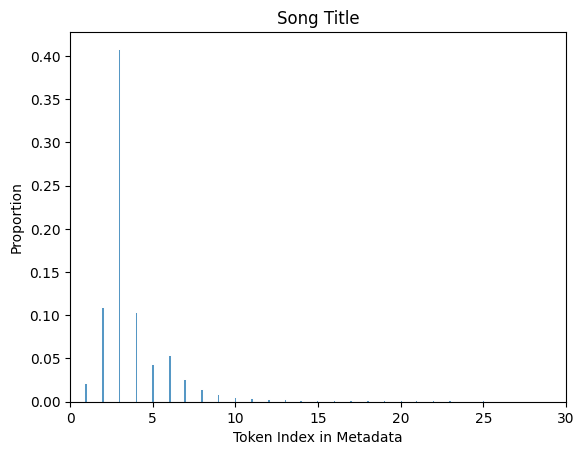

In [46]:
series_woa = data.IOB.apply(lambda x: get_first_idx(x, "B-WoA"))
series_artist = data.IOB.apply(lambda x: get_first_idx(x, "B-Artist"))

mask = data.part.isin(["medium", "both_100"])

sns.histplot(series_woa[mask], stat="proportion")
plt.title("Song Title")
plt.xlabel("Token Index in Metadata")
plt.xlim(0,30)
plt.show()


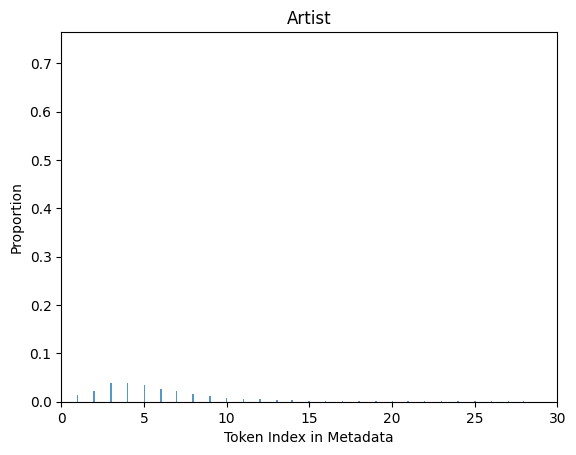

In [47]:
sns.histplot(series_artist[mask], stat="proportion")
plt.title("Artist")
plt.xlabel("Token Index in Metadata")
plt.xlim(0,30)
plt.show()


In [48]:
data[data.part == Artist_nan].sample(10)[["yt_processed", "performer_processed"]]


,yt_processed,performer_processed
78715,eddie arnold - then you can tell me goodbye. w...,[eddy arnold]
29697,house of the rising sun. 19leezal84.,[jypsi]
39791,babies go beatles vol.2 - the long and winding...,[sweet little band]
42101,miles davis love me or leave me. ficera.,[miles davis all stars]
11749,"""weird al"" yankovic: alapalooza - achy breaky ...",[weird al yankovic]
40875,i've grown accustomed to her face - braff 1991...,"[the ruby braff trio, ruby braff trio]"
30279,foo foo lammar - my way. melvin taylor. frank ...,[frank lammar]
13910,glee - abc (full performance) (official music ...,[glee cast]
104187,elton john - united we stand. indigoinsf3. he...,[reg dwight]
31839,letitbeme.mov. justin lee.,[inger marie gundersen]


In [49]:
data[data.part == WoA_nan].sample(10)[["yt_processed", "title_processed"]]


,yt_processed,title_processed
102921,"buddy guy- slippin' out, slippin in'. retrojen...","[someone else is steppin' in (slippin' out, sl..."
17711,"tom jones & emf ""unbelieveable"". goodbikes. ra...",[unbelievable]
96068,trio guadalajara -- cucurrucucu paloma. vintag...,[cu-cu-rru-cu-cu paloma]
97421,artema 〝believe〟. triple vision_jp. artema 〝be...,[believe]
39672,roger whittaker - you've lost that lovin' feel...,[you've lost that lovin' feelin']
275,can't help falling in love - bobby solo. radio...,[te ne vai]
3179,frank zander - er gehoert zu mir. dernachtwaec...,[er gehort zu mir]
87971,トラベシア ムーンライダース moonriders. naogimis. アルバムnouve...,[ [travessia]]
72375,lotte lehmann sings wiegenlied by schubert. ma...,"[cradle song (""wiegenlied""), cradle song]"
21369,glee p y t pretty young thing - glee cast si...,"[p.y.t. (pretty young thing), p.y.t.]"


### Check why an entity is not found
Debugging and understanding the partial matching for dataset creation

In [50]:
from rapidfuzz.fuzz import partial_ratio_alignment
import sys
sys.path.append("../preprocessing")
import importlib.util
from Utils import simplify_string

# Import the module
module_path = '../preprocessing/2_make_IOB_dataset.py'
module_name = '2_make_IOB_dataset'
spec = importlib.util.spec_from_file_location(module_name, module_path)
module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(module)


item = data.loc[47653]
text = simplify_string(item.yt_processed)
title = simplify_string(item.title[0].lower())
performer = simplify_string(item.performer[0].lower())

partial_ratio_alignment(text, title)

module.find_word_partial(text, title)


((2, 5), 90.0)

# Annotation Dataset Creation
Stratified sampling:
- Split: Test, Train, Val
- Missing attribute: WoA, Artist
